C:\Users\grzeg\AppData\Local\Temp\ipykernel_9160\2662702357.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
C:\Users\grzeg\AppData\Local\Temp\ipykernel_9160\2662702357.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


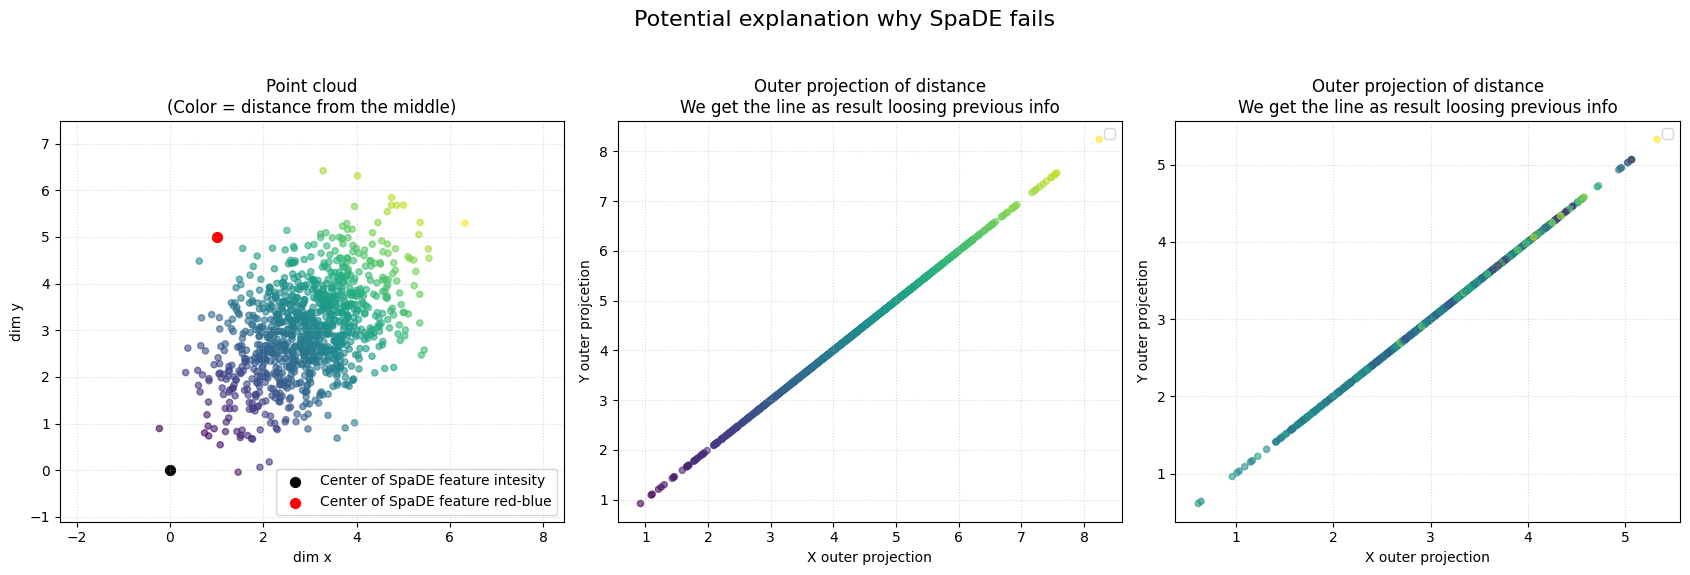

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# 1. Konfiguracja i generowanie danych
np.random.seed(42) # Dla powtarzalności wyników

# Parametry rozkładu (Środek w 0,0, rozkład sferyczny)
mean = [3, 3]
cov = [[1, 0.5], [0.5, 1]] 
num_samples = 1000  # Liczba punktów

# Generowanie chmury punktów (Kernel Gaussowski)
X = np.random.multivariate_normal(mean, cov, num_samples)

# Obliczenie odległości euklidesowej od środka dla każdego punktu (to będzie nasz kolor i oś Y prawego wykresu)
d1 = np.linalg.norm(X, axis=1)
d2 = np.linalg.norm(X - np.array([1, 5]), axis=1)

# 2. Projekcja liniowa
# Definiujemy wektor, na który rzutujemy (np. pod kątem 45 stopni)
v = np.array([1, 1])
v = v / np.linalg.norm(v) # Normalizacja do długości 1

# 3. Rysowanie wykresów
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 6))
colormap = cm.viridis # Mapa kolorów (fioletowy -> żółty)

# --- WYKRES LEWY: Przestrzeń 2D ---
# Rysujemy punkty
sc1 = ax1.scatter(X[:, 0], X[:, 1], c=d, cmap=colormap, alpha=0.6, s=20)

ax1.scatter(0, 0, color='black', s=50, label='Center of SpaDE feature intesity')
ax1.scatter(1, 5, color='red', s=50, label='Center of SpaDE feature red-blue')
ax1.set_title('Point cloud\n(Color = distance from the middle)')
ax1.set_xlabel('dim x')
ax1.set_ylabel('dim y')
ax1.axis('equal') # Ważne, żeby kółko było kółkiem
ax1.grid(True, linestyle=':', alpha=0.5)
ax1.legend()

# --- WYKRES PRAWY: Rzut vs Odległość ---
# Oś X: Wartość rzutu (gdzie punkt trafił na linii)
# Oś Y: Oryginalna odległość punktu (skąd przyszedł)
sc2 = ax2.scatter(d, d, c=d, cmap=colormap, alpha=0.6, s=20)

# Rysujemy teoretyczne granice (Kształt "V")
# Matematycznie: |rzut| nigdy nie może być większy niż odległość od środka.
# Czyli d >= |projection_val|    
ax2.set_title('Outer projection of distance\nWe get the line as result loosing previous info')
ax2.set_xlabel('X outer projection')
ax2.set_ylabel('Y outer projcetion')
ax2.grid(True, linestyle=':', alpha=0.5)
ax2.legend()


sc3 = ax3.scatter(d2, d2, c=d, cmap=colormap, alpha=0.6, s=20)

ax3.set_title('Outer projection of distance\nWe get the line as result loosing previous info')
ax3.set_xlabel('X outer projection')
ax3.set_ylabel('Y outer projcetion')
ax3.grid(True, linestyle=':', alpha=0.5)
ax3.legend()


plt.suptitle('Potential explanation why SpaDE fails', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


C:\Users\grzeg\AppData\Local\Temp\ipykernel_25368\2015107617.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


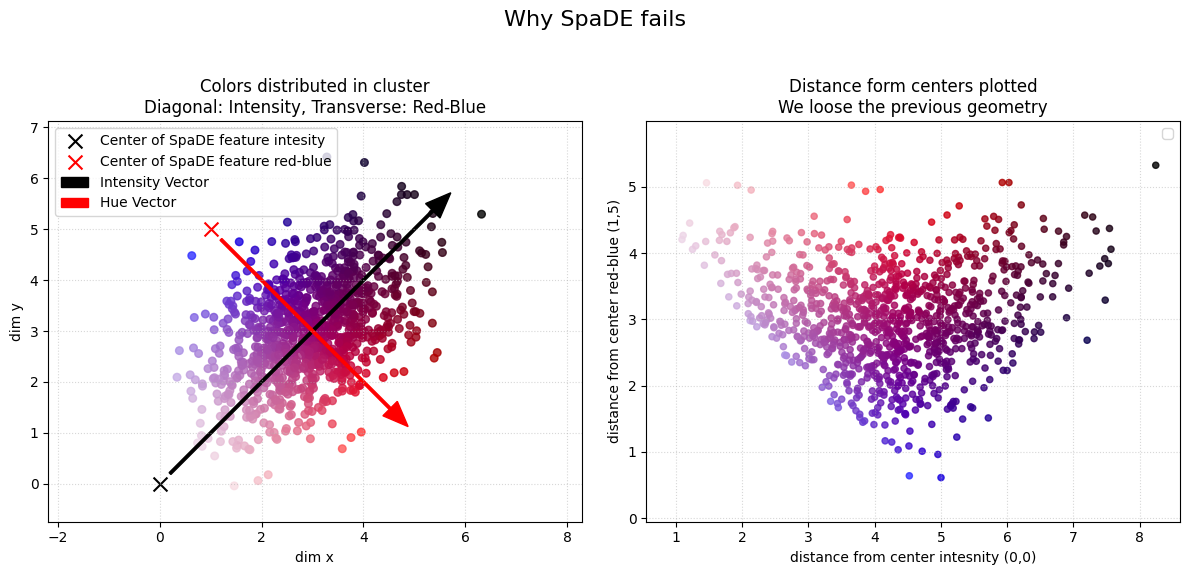

<Figure size 640x480 with 0 Axes>

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. Configuration and Data Generation
np.random.seed(42)
mean = [3, 3]
cov = [[1, 0.5], [0.5, 1]] 
num_samples = 1000 
X = np.random.multivariate_normal(mean, cov, num_samples)

d1 = np.linalg.norm(X, axis=1)
d2 = np.linalg.norm(X - np.array([1, 5]), axis=1)

# --- CUSTOM COLORING LOGIC ---

# Axis 1: Intensity (White -> Black) along y = x
# Vector [1, 1]
vec_intensity = np.array([1, 1])
vec_intensity = vec_intensity / np.linalg.norm(vec_intensity)

# Axis 2: Color (Red -> Blue) along y = -x + 6
# Vector [-1, 1] (perpendicular to intensity axis)
vec_color = np.array([-1, 1])
vec_color = vec_color / np.linalg.norm(vec_color)

# Calculate projections
# 1. Intensity projection (absolute position along diagonal)
proj_intensity = X @ vec_intensity 
# Normalize to 0-1 range based on data distribution
norm_intensity = (proj_intensity - proj_intensity.min()) / (proj_intensity.max() - proj_intensity.min())

# 2. Color projection (relative to center [3,3])
proj_color = (X - np.array([3, 3])) @ vec_color
# Normalize to 0-1 range
norm_color = (proj_color - proj_color.min()) / (proj_color.max() - proj_color.min())

# Create custom color array
# Define base colormap for Hue (Red to Blue)
cmap_rb = mcolors.LinearSegmentedColormap.from_list("RedBlue", ["red", "blue"])

final_colors = np.zeros((num_samples, 4)) # RGBA array

for i in range(num_samples):
    # Get base hue (Red/Blue)
    base_rgba = cmap_rb(norm_color[i])
    base_rgb = np.array(base_rgba[:3])
    
    # Apply intensity mixing: White -> Color -> Black
    t = norm_intensity[i] # 0.0 (Start) to 1.0 (End)
    
    if t < 0.5:
        # First half: Interpolate White -> Base Color
        factor = t * 2 # Scale 0..0.5 to 0..1
        # (1-f)*White + f*Color
        rgb = (1 - factor) * np.array([1.0, 1.0, 1.0]) + factor * base_rgb
    else:
        # Second half: Interpolate Base Color -> Black
        factor = (t - 0.5) * 2 # Scale 0.5..1 to 0..1
        # (1-f)*Color + f*Black
        rgb = (1 - factor) * base_rgb + factor * np.array([0.0, 0.0, 0.0])
        
    final_colors[i, :3] = rgb
    final_colors[i, 3] = 0.8 # Alpha (transparency)

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: 2D Space
ax1.scatter(X[:, 0], X[:, 1], c=final_colors, s=30)
ax1.scatter(0, 0, color='black', s=100, marker='x', label='Center of SpaDE feature intesity')
ax1.scatter(1, 5, color='red', s=100, marker='x', label='Center of SpaDE feature red-blue')
ax1.set_title('Colors distributed in cluster\nDiagonal: Intensity, Transverse: Red-Blue')
ax1.set_xlabel('dim x')
ax1.set_ylabel('dim y')
ax1.axis('equal')
ax1.grid(True, linestyle=':', alpha=0.5)

# Add reference lines for clarity
# Strzałka 1: Intensywność (z 0,0 w kierunku 1,1)
# Skalujemy wektor, żeby był widoczny na tle chmury (długość np. 4 jednostki)
margin = 0.2
arrow_len = 8.0 -margin

ax1.arrow(0 + margin, 0 + margin , 
          vec_intensity[0] * arrow_len, vec_intensity[1] * arrow_len,
          head_width=0.4, head_length=0.5, fc='black', ec='black', 
          width=0.05, length_includes_head=True, label='Intensity Vector')

# Strzałka 2: Kolor (z 1,5 w kierunku -1,1 - czyli w stronę "Niebieską")
# Punkt (1,5) leży na linii y=-x+6, więc jest to geometrycznie poprawne
ax1.arrow(1 + margin, 5 - margin, 
          -vec_color[0] * (arrow_len/1.5), -vec_color[1] * (arrow_len/1.5), # Krótsza strzałka bo chmura jest węższa
          head_width=0.4, head_length=0.5, fc='red', ec='red', 
          width=0.05, length_includes_head=True, label='Hue Vector')
ax1.legend()

# --- WYKRES PRAWY: Rzut vs Odległość ---
# Oś X: Wartość rzutu (gdzie punkt trafił na linii)
# Oś Y: Oryginalna odległość punktu (skąd przyszedł)
sc2 = ax2.scatter(d1, d2, c=final_colors, s=20)

# Rysujemy teoretyczne granice (Kształt "V")
# Matematycznie: |rzut| nigdy nie może być większy niż odległość od środka.
# Czyli d >= |projection_val|    
ax2.set_title('Distance form centers plotted\nWe loose the previous geometry')
ax2.set_xlabel('distance from center intesnity (0,0)')
ax2.set_ylabel('distance from center red-blue (1,5)')
ax2.grid(True, linestyle=':', alpha=0.5)
ax2.axis('equal')
ax2.legend()


plt.suptitle('Why SpaDE fails', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.tight_layout()
plt.show()

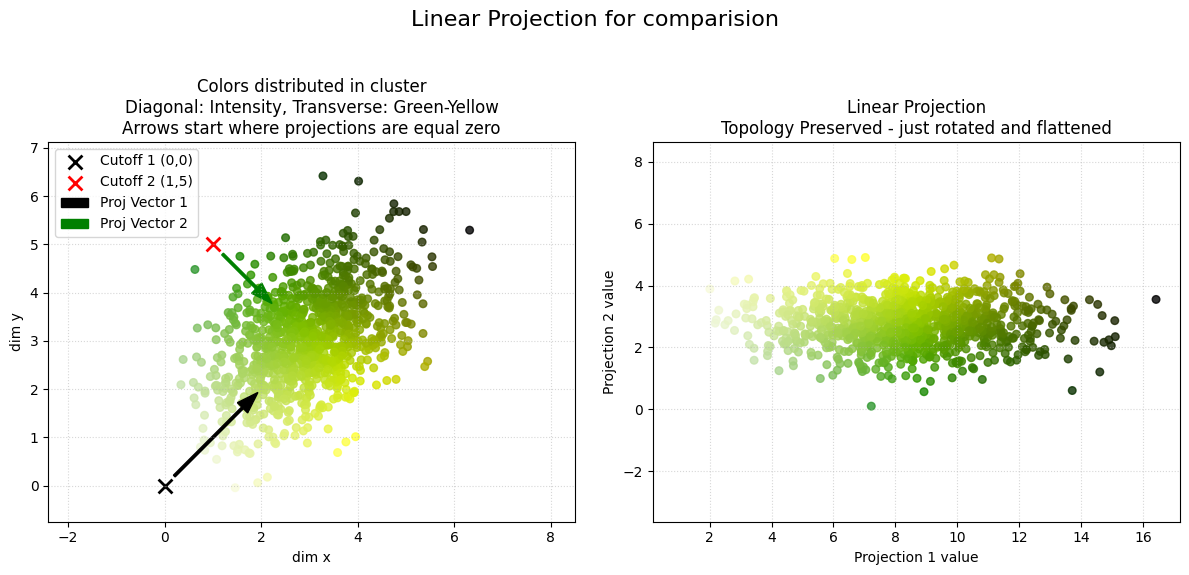

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. Konfiguracja i generowanie danych
np.random.seed(42)
mean = [3, 3]
cov = [[1, 0.5], [0.5, 1]] 
num_samples = 1000 
X = np.random.multivariate_normal(mean, cov, num_samples)

# --- DEFINICJA "ŚRODKÓW" (Jako punktów zaczepienia wektorów / BIAS) ---
center1 = np.array([0, 0]) # "Intensity center"
center2 = np.array([1, 5]) # "Red-Blue center"

# --- DEFINICJA WEKTORÓW KIERUNKOWYCH ---
# Kierunek 1: Przekątna
v1 = np.array([1, 1])
v1 = v1 / np.linalg.norm(v1)*2

# Kierunek 2: Prostopadły
# Uwaga: Twoje skalowanie (/2) sprawia, że ta cecha jest "spłaszczona" (ma mniejszą wagę)
v2 = np.array([1, -1])
v2 = v2 / np.linalg.norm(v2)

# --- OBLICZENIA: Projekcja Liniowa z przesunięciem (Bias) ---
# Wzór: (X - Center) * v
# To symuluje neuron, który "patrzy" z punktu Center w kierunku v.
proj1 = (X - center1) @ v1 
proj2 = (X - center2) @ v2 

# --- LOGIKA KOLOROWANIA ---
norm_intensity = (proj1 - proj1.min()) / (proj1.max() - proj1.min())
norm_color = (proj2 - proj2.min()) / (proj2.max() - proj2.min())

# Mapa Green-Yellow (jak w Twoim kodzie)
cmap_rb = mcolors.LinearSegmentedColormap.from_list("GreenYellow", ["green", "yellow"])
final_colors = np.zeros((num_samples, 4)) 

for i in range(num_samples):
    base_rgba = cmap_rb(norm_color[i])
    base_rgb = np.array(base_rgba[:3])
    t = norm_intensity[i]
    
    if t < 0.5:
        factor = t * 2 
        rgb = (1 - factor) * np.array([1.0, 1.0, 1.0]) + factor * base_rgb
    else:
        factor = (t - 0.5) * 2 
        rgb = (1 - factor) * base_rgb + factor * np.array([0.0, 0.0, 0.0])
    final_colors[i, :3] = rgb
    final_colors[i, 3] = 0.8 

# --- RYSOWANIE ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# --- WYKRES 1: Oryginalna Przestrzeń ---
ax1.scatter(X[:, 0], X[:, 1], c=final_colors, s=30, alpha=0.8)

# Rysujemy ŚRODKI (Centers) jako punkty odniesienia
ax1.scatter(center1[0], center1[1], c='black', marker='x', s=100, linewidth=2, label='Cutoff 1 (0,0)')
ax1.scatter(center2[0], center2[1], c='red', marker='x', s=100, linewidth=2, label='Cutoff 2 (1,5)')

# Rysujemy WEKTORY zaczepione w tych środkach
# Skala wizualna (żeby strzałki były widoczne)
# scale_vis = 4.0

# Wektor 1 (Czarny) zaczyna się w (0,0)
ax1.arrow(center1[0] + margin, center1[1] + margin, v1[0], v1[1], 
          head_width=0.3, fc='black', ec='black', width=0.05, label='Proj Vector 1')

# Wektor 2 (Czerwony/Zielony) zaczyna się w (1,5)
# Uwaga: v2 jest już podzielone przez 2 w definicji, więc strzałka będzie naturalnie krótsza
# Mnożymy przez scale_vis * 2, żeby wizualnie miała podobną długość do v1, 
# albo zostawiamy jak jest, żeby pokazać że waga jest mniejsza. Zostawię skalowanie v1.
ax1.arrow(center2[0] + margin, center2[1] - margin, v2[0], v2[1], 
          head_width=0.3, fc='green', ec='green', width=0.05, label='Proj Vector 2')

ax1.set_title('Colors distributed in cluster\nDiagonal: Intensity, Transverse: Green-Yellow\nArrows start where projections are equal zero')
ax1.set_xlabel('dim x')
ax1.set_ylabel('dim y')
ax1.axis('equal')
ax1.grid(True, linestyle=':', alpha=0.5)
ax1.legend()

# --- WYKRES 2: Wynik Projekcji ---
ax2.scatter(proj1, proj2, c=final_colors, s=30, alpha=0.8)

ax2.set_title('Linear Projection\nTopology Preserved - just rotated and flattened')
ax2.set_xlabel('Projection 1 value')
ax2.set_ylabel('Projection 2 value')
ax2.axis('equal')
ax2.grid(True, linestyle=':', alpha=0.5)

plt.suptitle('Linear Projection for comparision', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()